## Modeling for predicting hospitalization at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [90]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.saving import register_keras_serializable
from helpers import PlotROCCurve

from dataset_path import output_path

path = "/mnt/mimic/mgrzeszczyk/data/ed"
output_path = os.path.join(path, "Task1")
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed=0

In [2]:
random.seed(random_seed)
np.random.seed(random_seed)

In [3]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 
df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,anchor_age,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,Other,2180,52,False,0 days 04:13:00,NaN,NaN,False,True,False,0,0,0,2180-06-26 15:54:00,50 days 16:24:00,False,0,0,0,0,0,0,4.22,NaN,50.68,36.888889,70.0,16.0,97.0,106.0,63.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.500000,79.0,16.0,98.0,107.0,60.0,0.0,0.0,9.0,77.333333,1,0,2,1,1,1
1,1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,Medicaid,2180,52,False,0 days 05:37:00,NaN,NaN,False,True,False,0,1,1,2180-07-22 16:24:00,25 days 18:53:00,False,0,1,1,0,0,0,5.62,NaN,25.79,37.166667,88.0,18.0,97.0,116.0,88.0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,36.611111,86.0,17.0,93.0,96.0,57.0,5.0,3.0,12.0,97.333333,6,0,2,0,0,1
2,3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME,52,2180,2180-09-09,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,Medicaid,2180,52,False,0 days 13:30:00,2180-07-23 14:00:00,0 days 08:06:00,True,True,True,1,2,2,2180-07-23 05:54:00,0 days 00:00:00,True,1,2,2,0,0,0,13.50,8.1,0.00,36.555556,87.0,14.0,97.0,71.0,43.0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,36.777778,85.0,18.0,98.0,81.0,38.0,0.0,2.0,14.0,52.333333,6,4,4,3,3,2
3,4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,Medicaid,2180,52,False,0 days 08:06:00,2180-07-23 14:00:00,0 days 00:00:00,True,True,True,2,3,3,2180-08-05 20:58:00,13 days 06:58:00,False,1,2,2,0,0,0,8.10,0.0,13.29,37.055556,77.0,16.0,98.0,96.0,50.0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,37.222222,96.0,18.0,97.0,86.0,45.0,0.0,8.0,14.0,65.333333,6,0,4,2,2,2
4,2,10000032,25742920.0,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,Medicaid,2180,52,False,0 days 04:46:00,NaN,NaN,False,True,False,2,3,4,NaN,NaN,False,1,2,3,1,1,1,4.77,NaN,NaN,37.444444,105.0,18.0,96.0,106.0,57.0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,36.722222,91.0,18.0,99.0,98.0,60.0,0.0,6.0,7.0,73.333333,6,0,2,2,2,2


### 1. Task-specific filter: No task-specific exclusion needed

In [4]:
print('training size =', len(df_train), ', testing size =', len(df_test))

training size = 376302 , testing size = 41798


### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_hospitalization"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [7]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [8]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [9]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.8977643516720712 : 1


### 3.  Modeling script

In [10]:
# Containers for all results
result_list = []

Logistic Regression:


/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 7.619207859039307 seconds
AUC: 0.808724457777744
AUPRC: 0.7728953213663214
Sensitivity: 0.7509212983997173
Specificity: 0.7230888171358407
Score thresold: 0.4398636191770744
2.5 97.5


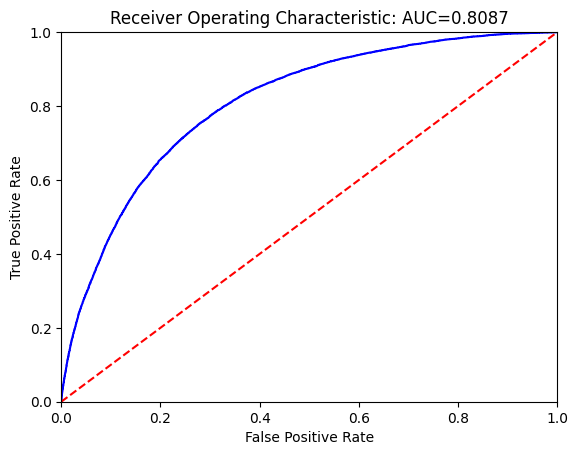

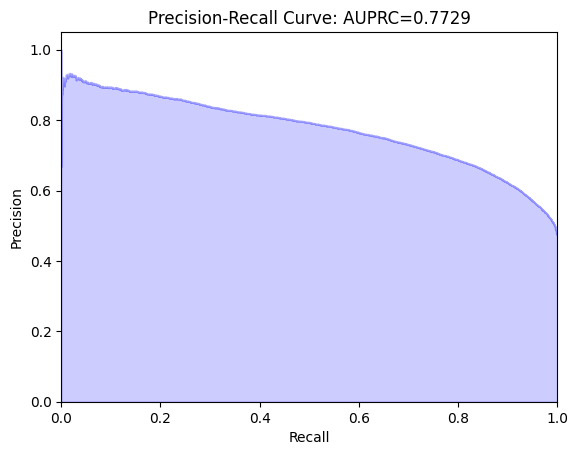

In [11]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
import pickle
with open('task1_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



RandomForest:
Training time: 86.79676699638367 seconds
AUC: 0.8173000974624413
AUPRC: 0.7846642012866472
Sensitivity: 0.767126053813923
Specificity: 0.7164036563736413
Score thresold: 0.4725
2.5 97.5


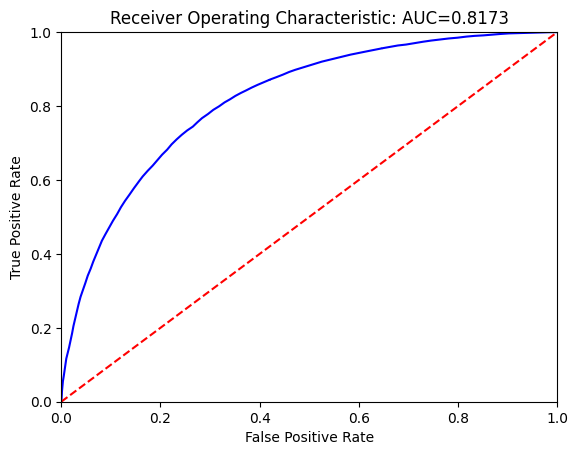

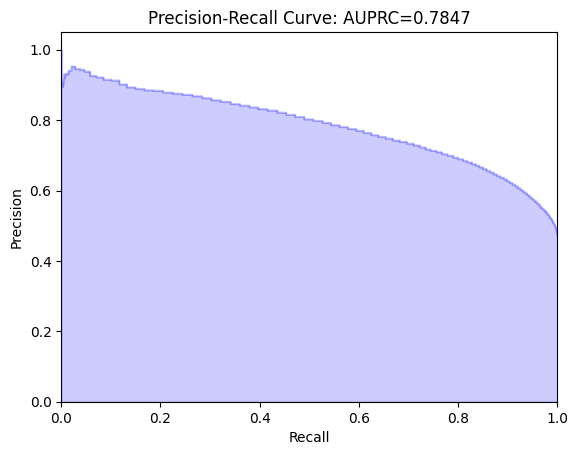

[0.12679083 0.01294818 0.00760454 0.01134347 0.02217879 0.00630318
 0.01514934 0.02797295 0.00075718 0.00176065 0.00490923 0.0783333
 0.08544073 0.04033772 0.04194793 0.08707604 0.08297321 0.04783545
 0.11199565 0.00699882 0.00891817 0.00508259 0.00054152 0.00425144
 0.00278071 0.00384376 0.00414567 0.00344842 0.0041056  0.00340375
 0.00565152 0.00296543 0.00303297 0.00140929 0.0061785  0.00219585
 0.00148732 0.00384615 0.006007   0.00341198 0.00120856 0.0059378
 0.00424494 0.00141861 0.00207061 0.00107396 0.00811358 0.00275646
 0.00242363 0.00484775 0.01002425 0.00459299 0.00431196 0.00095457
 0.00383831 0.00476782 0.00354088 0.01246461 0.00114267 0.00336705
 0.00484463 0.00413156 0.00281522 0.00774274]


In [12]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 81.9288878440857 seconds
AUC: 0.8186595615395204
AUPRC: 0.7923458125757148
Sensitivity: 0.7533444393962341
Specificity: 0.7280458411023694
Score thresold: 0.4773695787181356
2.5 97.5


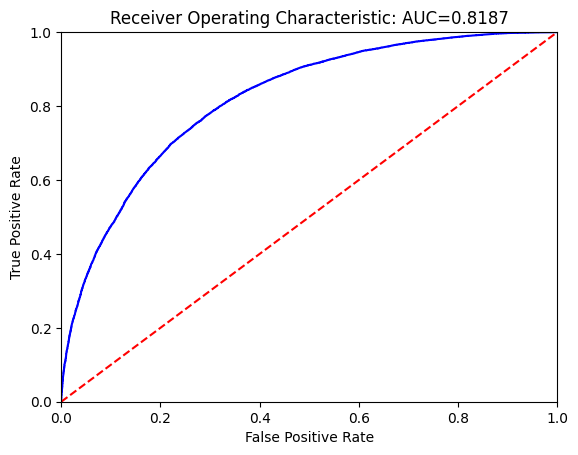

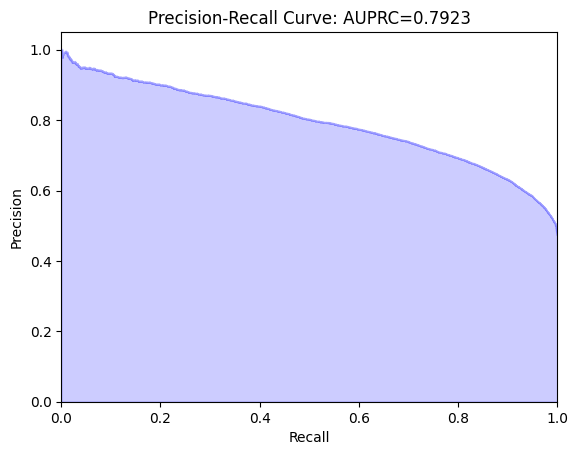

In [13]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [22]:
@register_keras_serializable()
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [18]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy', 'AUC', metrics.AUC(name='auprc', curve='PR'),
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('hospitalization_triage_mlp.keras')

MLP:
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step
AUC: 0.8233738804335324
AUPRC: 0.7970327486122066
Sensitivity: 0.7479933363622596
Specificity: 0.7404611396607395
Score thresold: 0.5311532
2.5 97.5


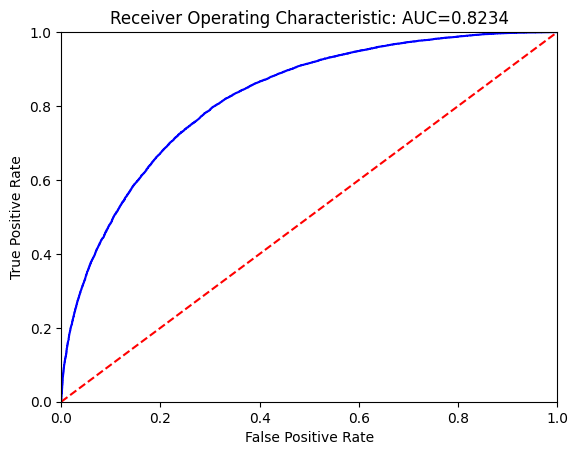

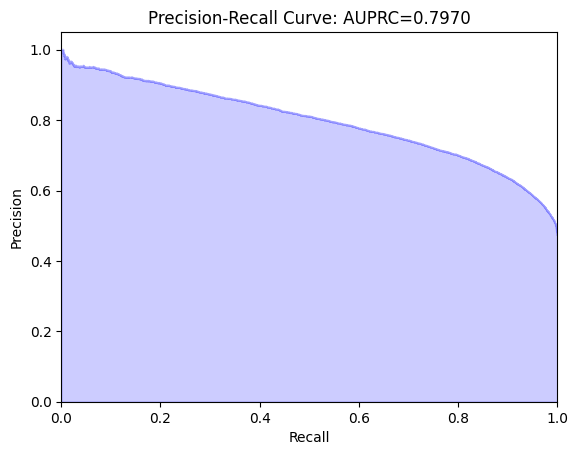

In [23]:
print("MLP:")
# mlp = load_model('hospitalization_triage_mlp.keras')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [24]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


esi
AUC: 0.7115008095835855
AUPRC: 0.6316415103844218
Sensitivity: 0.5838255338482508
Specificity: 0.7840283778252762
Score thresold: -2.0
2.5 97.5


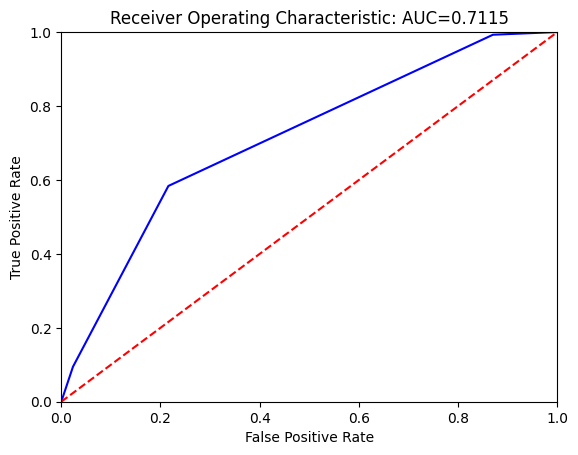

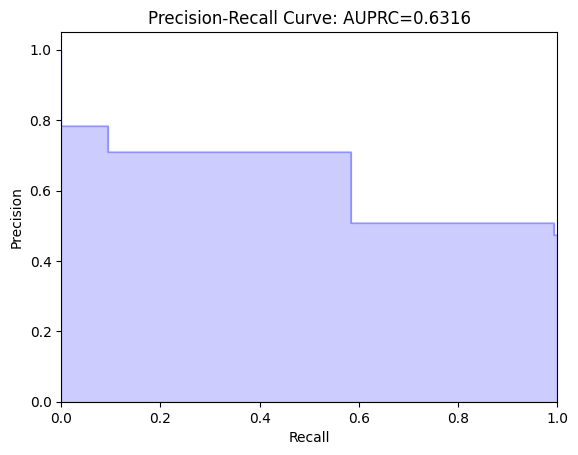

In [25]:
df_test["esi"] = -df_test["triage_acuity"]
get_score_performance("esi", random_seed=random_seed)

In [26]:
## input AutoScore result from csv (implemented by R, detail: https://github.com/nliulab/AutoScore) TODO add AutoScore
# AutoScore_pred = pd.read_csv((os.path.join(path, 'AutoScore_Hospitalization.csv')))
# df_test["AutoScore"] = AutoScore_pred["pred_score"]
# get_score_performance("AutoScore", random_seed=random_seed)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/mimic/mgrzeszczyk/data/ed/AutoScore_Hospitalization.csv'

score_NEWS
AUC: 0.580974027323622
AUPRC: 0.5545517625037015
Sensitivity: 0.562925942753294
Specificity: 0.5463186138523808
Score thresold: 1.0
2.5 97.5


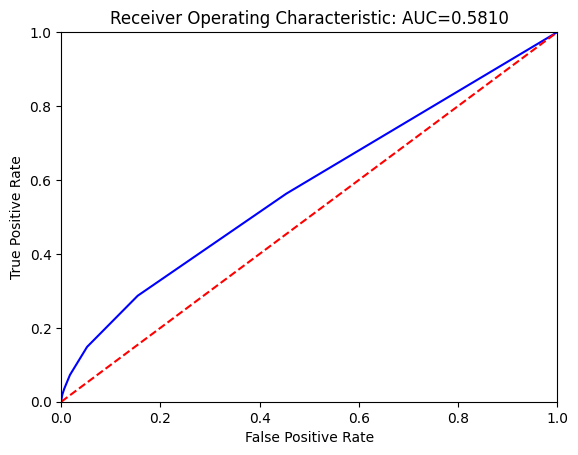

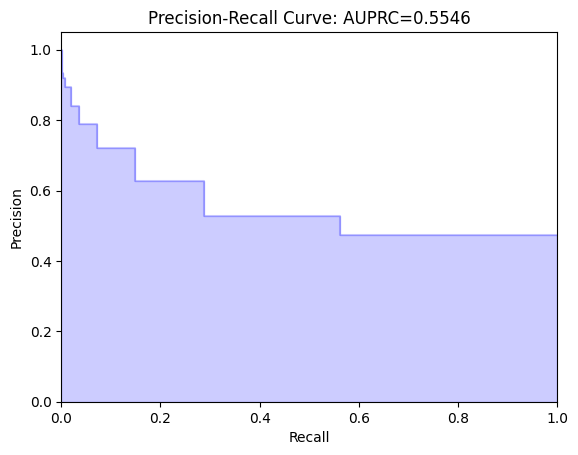

In [28]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.5647588570626646
AUPRC: 0.5380764155915607
Sensitivity: 0.5188550658791459
Specificity: 0.5702851425712856
Score thresold: 1.0
2.5 97.5


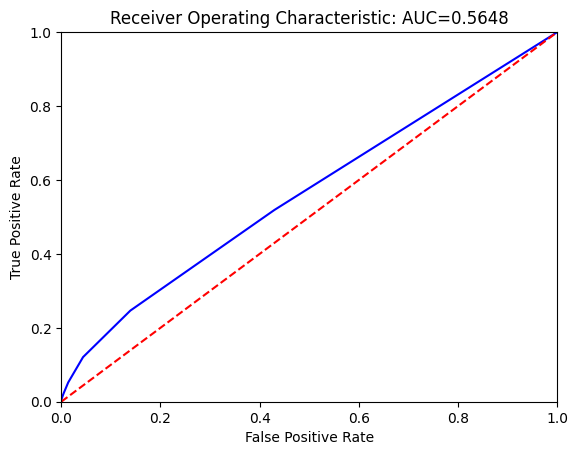

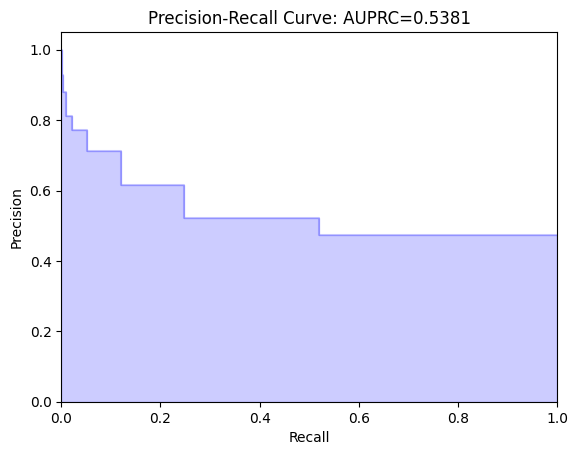

In [29]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6664679649817152
AUPRC: 0.6048628583224261
Sensitivity: 0.6053309101923369
Specificity: 0.641457092182455
Score thresold: 4.0
2.5 97.5


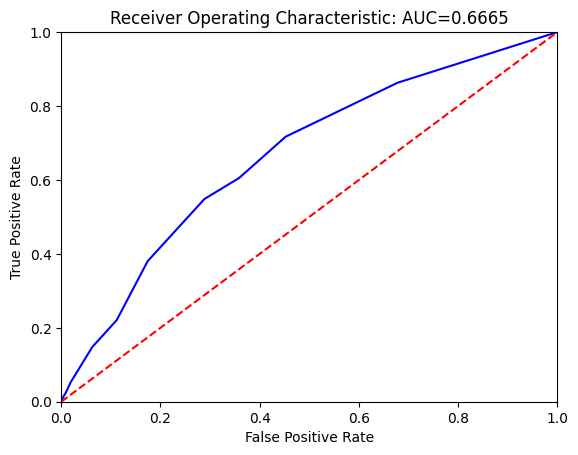

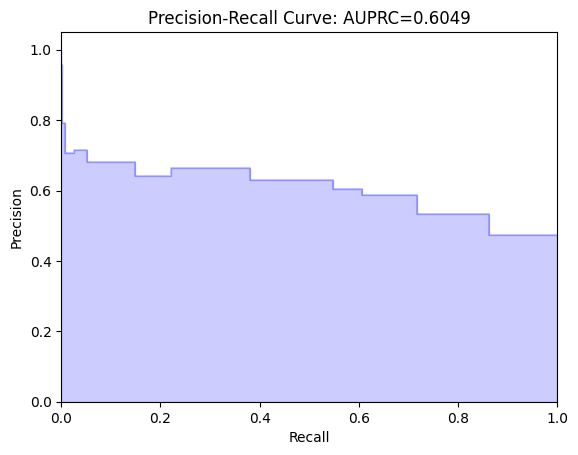

In [30]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.5575748534940536
AUPRC: 0.5211565286079426
Sensitivity: 0.29587561209551216
Specificity: 0.8117240438401019
Score thresold: 2.0
2.5 97.5


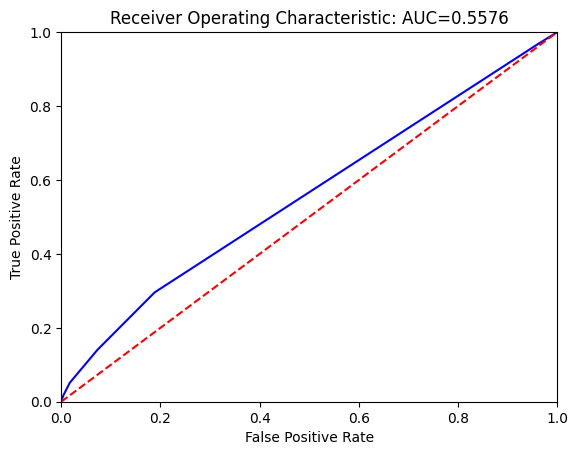

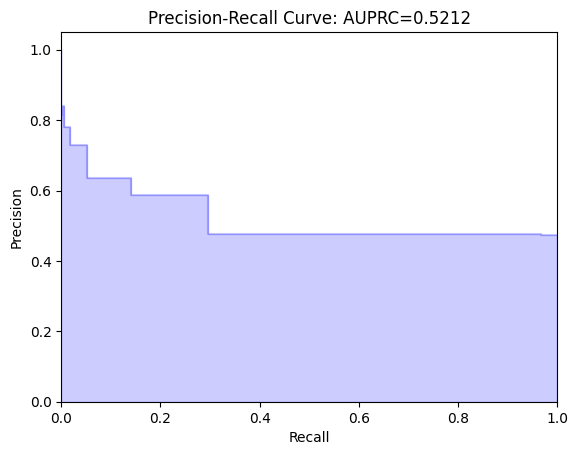

In [31]:
get_score_performance("score_MEWS", random_seed=random_seed)

score_CART
AUC: 0.6729784471949513
AUPRC: 0.6171434633269111
Sensitivity: 0.7029632995103235
Specificity: 0.5781072354358998
Score thresold: 4.0
2.5 97.5


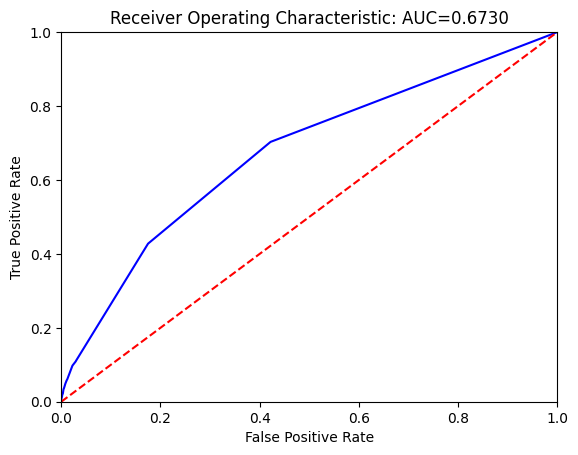

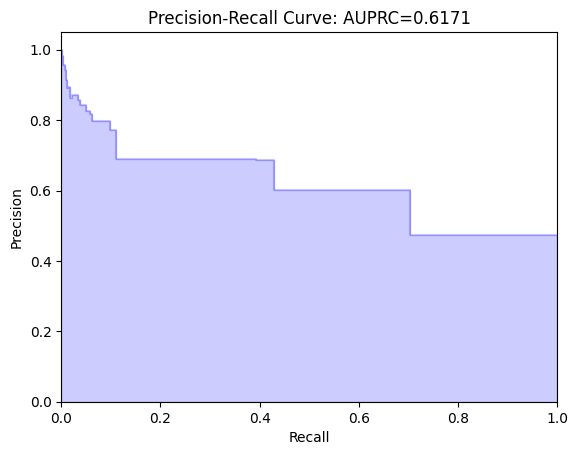

In [32]:
get_score_performance("score_CART", random_seed=random_seed)

In [80]:
import importlib
import embedding
importlib.reload(embedding)
import tensorflow.keras as keras
from tensorflow.keras import optimizers, metrics, layers, Model

[autoreload of embedding failed: Traceback (most recent call last):
  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/

In [77]:
print("Med2Vec:")
version = 'v10'
batch_size=200
vocabulary = embedding.vocabulary_map[version]
df_icd_encode = pd.read_csv(os.path.join(path, 'icd_list_dataset_'+version+'.csv'))
df_train_embed = pd.merge(df_train, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
df_test_embed = pd.merge(df_test, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')

train_gen, test_gen = embedding.setup_embedding_data(df_train_embed, df_test_embed, X_train, y_train, X_test, y_test, batch_size)


Med2Vec:


In [81]:
# To train from scratch, set load_model to None
load_model = None#"embedding_hospitalization_"+version 
save_model = "embedding_hospitalization_"+version +".keras"

if load_model:
        model = keras.models.load_model(load_model)
else:
        model = embedding.create_embedding_model(vocabulary, len(variable))
model.summary()
model.compile(loss='binary_crossentropy', 
        optimizer=optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy', 'AUC', metrics.AUC(name='auprc', curve='PR'),
                    'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
runtime = 1063.299 # to be updated
if not load_model:
        start = time.time()
        model.fit(train_gen, epochs=100)
        runtime = time.time()-start
        print('Training time:', runtime, 'seconds')
if save_model:
        keras.models.save_model(model, save_model)
output = model.predict(test_gen)
result = PlotROCCurve(output,y_test, ci=confidence_interval, random_seed=random_seed)

results = ["Med2Vec"]
results.extend(result)
results.append(runtime)
result_list.append(results)

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'lambda_3' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ icd_input           │ (None, 14954)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_15        │ (None, 14954,     │ 15,313,920 │ icd_input[0][0]   │
│ (Embedding)         │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_18        │ (None, 14954,     │          0 │ embedding_15[0][… │
│ (NotEqual)          │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_2 (Masking) │ (None, 14954,     │          0 │ embedding_15[0][… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_2 (Any)         │ (None, 14954)     │          0 │ not_equal_18[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 1024)      │          0 │ masking_2[0][0],  │
│                     │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 256)       │    262,400 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demograph_input     │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 320)       │          0 │ dense_47[0][0],   │
│ (Concatenate)       │                   │            │ demograph_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 128)       │     41,088 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 50)        │      6,450 │ dense_48[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 1)         │         51 │ dense_49[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,623,909 (59.60 MB)

 Trainable params: 15,623,909 (59.60 MB)

 Non-trainable params: 0 (0.00 B)

/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
2024-12-02 17:43:18.956229: W tensorflow/core/framework/op_kernel.cc:1829] INVALID_ARGUMENT: TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was ((tf.float32, tf.int64), tf.float32, tf.float32), but the yielded element was ((<tf.Tensor: shape=(200, 64), dtype=float32, numpy=
array([[73.,  1.,  0., ...,  0.,  0.,  0.],
       [49.,  1.,  0., ...,  0.,  0.,  0.],
       [50.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [59.,  1.,  1., ...,  1.,  0.,  0.],
       [59.,  1.,  0., ...,  1.,  0.,  0.],
       [60.,  1.,  0., ...,  1.,  0.,  0.]], dtype=float32)>, <tf.Tensor: shape=(200, 73), dtype=int64, numpy=
array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],

InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was ((tf.float32, tf.int64), tf.float32, tf.float32), but the yielded element was ((<tf.Tensor: shape=(200, 64), dtype=float32, numpy=
array([[73.,  1.,  0., ...,  0.,  0.,  0.],
       [49.,  1.,  0., ...,  0.,  0.,  0.],
       [50.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [59.,  1.,  1., ...,  1.,  0.,  0.],
       [59.,  1.,  0., ...,  1.,  0.,  0.],
       [60.,  1.,  0., ...,  1.,  0.,  0.]], dtype=float32)>, <tf.Tensor: shape=(200, 73), dtype=int64, numpy=
array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [10804,  5906,  4229, ...,     0,     0,     0],
       ...,
       [12957,  4404,  5972, ...,     0,     0,     0],
       [12957,  4404,  5972, ...,     0,     0,     0],
       [12957,  4404,  5972, ...,     0,     0,     0]])>), <tf.Tensor: shape=(200,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>).
Traceback (most recent call last):

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 204, in generator_py_func
    flattened_values = nest.flatten_up_to(output_types, values)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/tensorflow/python/data/util/nest.py", line 237, in flatten_up_to
    return nest_util.flatten_up_to(
           ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/tensorflow/python/util/nest_util.py", line 1541, in flatten_up_to
    return _tf_data_flatten_up_to(shallow_tree, input_tree)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/tensorflow/python/util/nest_util.py", line 1570, in _tf_data_flatten_up_to
    _tf_data_assert_shallow_structure(shallow_tree, input_tree)

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/tensorflow/python/util/nest_util.py", line 1427, in _tf_data_assert_shallow_structure
    raise ValueError(

ValueError: The two structures don't have the same sequence length. Input structure has length 2, while shallow structure has length 3.


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/home/local/PARTNERS/mg1258/miniconda3/envs/ed/lib/python3.11/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 206, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was ((tf.float32, tf.int64), tf.float32, tf.float32), but the yielded element was ((<tf.Tensor: shape=(200, 64), dtype=float32, numpy=
array([[73.,  1.,  0., ...,  0.,  0.,  0.],
       [49.,  1.,  0., ...,  0.,  0.,  0.],
       [50.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [59.,  1.,  1., ...,  1.,  0.,  0.],
       [59.,  1.,  0., ...,  1.,  0.,  0.],
       [60.,  1.,  0., ...,  1.,  0.,  0.]], dtype=float32)>, <tf.Tensor: shape=(200, 73), dtype=int64, numpy=
array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [10804,  5906,  4229, ...,     0,     0,     0],
       ...,
       [12957,  4404,  5972, ...,     0,     0,     0],
       [12957,  4404,  5972, ...,     0,     0,     0],
       [12957,  4404,  5972, ...,     0,     0,     0]])>), <tf.Tensor: shape=(200,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>).


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_480924]

### 4. Performance output

In [86]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 
                                               'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 
                                               'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity',
                                               'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)

result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(output_path, 'task1.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.440,0.809 (0.807-0.813),0.773 (0.77-0.78),0.751 (0.729-0.757),0.723 (0.72-0.747),7.619
1,RF,0.472,0.817 (0.814-0.821),0.785 (0.778-0.791),0.767 (0.735-0.773),0.716 (0.714-0.748),86.797
2,GB,0.477,0.819 (0.816-0.822),0.792 (0.787-0.797),0.753 (0.732-0.771),0.728 (0.712-0.75),81.929
3,MLP,0.531,0.823 (0.821-0.827),0.797 (0.792-0.803),0.748 (0.74-0.778),0.74 (0.72-0.752),67.840
4,esi,-2.000,0.712 (0.708-0.716),0.632 (0.628-0.639),0.584 (0.577-0.591),0.784 (0.782-0.79),0.000
5,score_NEWS,1.000,0.581 (0.577-0.585),0.555 (0.548-0.559),0.563 (0.554-0.568),0.546 (0.542-0.552),0.000
6,score_NEWS2,1.000,0.565 (0.561-0.569),0.538 (0.532-0.543),0.519 (0.51-0.526),0.57 (0.567-0.576),0.000
7,score_REMS,4.000,0.666 (0.661-0.669),0.605 (0.599-0.61),0.605 (0.553-0.717),0.641 (0.544-0.712),0.000
8,score_MEWS,2.000,0.558 (0.555-0.561),0.521 (0.516-0.527),0.296 (0.292-0.299),0.812 (0.807-0.817),0.000
9,score_CART,4.000,0.673 (0.668-0.676),0.617 (0.609-0.622),0.703 (0.699-0.707),0.578 (0.571-0.583),0.000


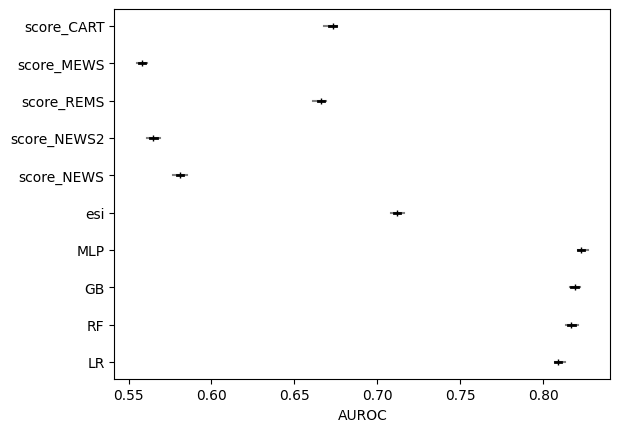

In [91]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_hosp.eps', my_path = output_path)

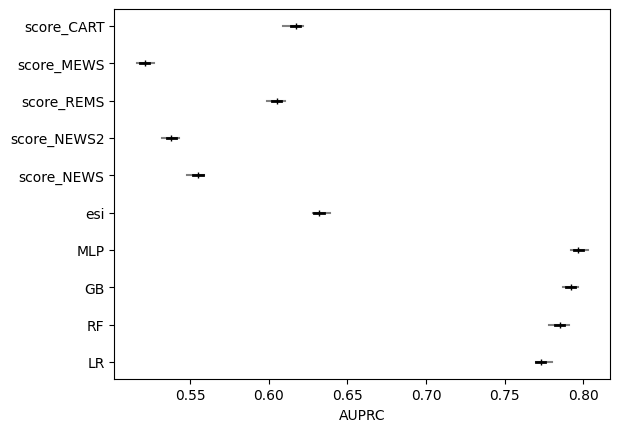

In [92]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_hosp.eps', my_path = output_path)

In [85]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_hospitalization_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,age,0.126791
18,triage_acuity,0.111996
15,triage_sbp,0.087076
12,triage_heartrate,0.085441
16,triage_dbp,0.082973
11,triage_temperature,0.078333
17,triage_pain,0.047835
14,triage_o2sat,0.041948
13,triage_resprate,0.040338
7,n_hosp_365d,0.027973
